In [48]:
import os
import random
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import torch
from torch.utils.data import DataLoader, random_split

from Loading import read_test_data_properties, read_train_data_properties
from Loading import read_image, read_mask
from Loading import LoadDataSet, get_train_transform
from Model import UNet
from Loss import DiceLoss, IoULoss
from utils import save_ckp, load_ckp, plot_data_shape_dist

plt.rcParams["figure.figsize"] = (20, 8)
# pd.set_option('display.max_colwidth', None)   # if you need to see whole output

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
print(torch.cuda.is_available())
device

False


device(type='cpu')

In [4]:
TRAIN_PATH = '../data-science-bowl-2018/stage1_train'
TEST_PATH = '../data-science-bowl-2018/stage1_test'
IMG_DIR_NAME = 'images'
MASK_DIR_NAME = 'masks'

checkpoint_path = 'checkpoints/chkpoint_'
best_model_path = 'checkpoints/bestmodel.pt'
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

In [5]:
train_df, train_data = read_train_data_properties(TRAIN_PATH, IMG_DIR_NAME, MASK_DIR_NAME)
test_df, test_data = read_test_data_properties(TEST_PATH, IMG_DIR_NAME)

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 207.22it/s]


In [6]:
print(f"train data size: {len(train_data)}\ntest  data size: {len(test_data)}")

train data size: 670
test  data size: 65


In [7]:
train_df.head(2)

,id,height,width,num_masks,image_path,mask_dir
0,1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20...,256,320,17,../data-science-bowl-2018/stage1_train/1d02c4b...,../data-science-bowl-2018/stage1_train/1d02c4b...
1,12f89395ad5d21491ab9cec137e247652451d283064773...,256,256,78,../data-science-bowl-2018/stage1_train/12f8939...,../data-science-bowl-2018/stage1_train/12f8939...


In [8]:
test_df.head(2)

,id,height,width,image_path
0,bdc789019cee8ddfae20d5f769299993b4b330b2d38d12...,520,696,../data-science-bowl-2018/stage1_test/bdc78901...
1,b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65...,524,348,../data-science-bowl-2018/stage1_test/b83d1d77...


<AxesSubplot:ylabel='Frequency'>

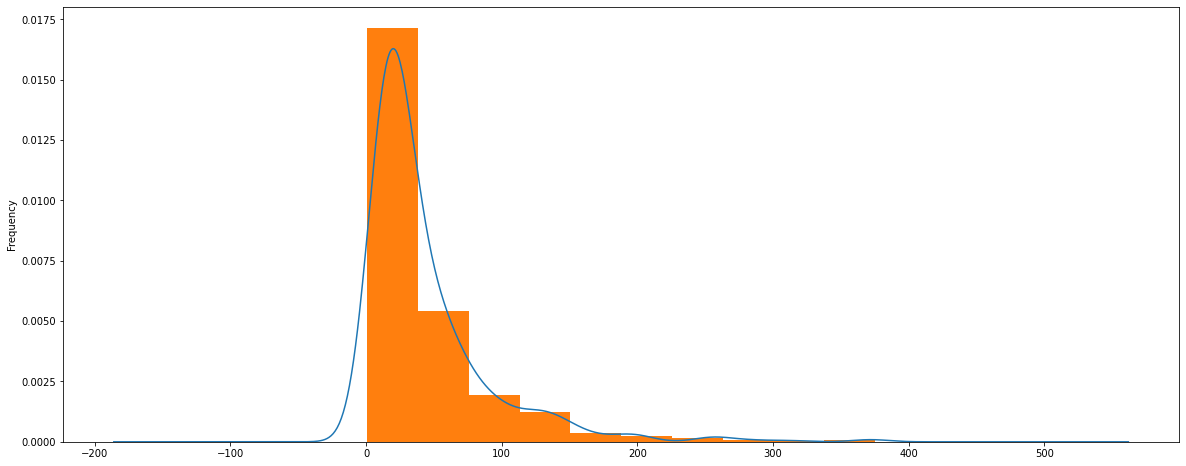

In [9]:
train_df['num_masks'].plot.kde()
train_df['num_masks'].plot.hist(density=True)

In [51]:
report = ProfileReport(train_df[["height", "width", "num_masks", "shape"]])
report

/home/raphael/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(f"minimum number of masks: {train_df['num_masks'].min()}")
print(f"maximum number of masks: {train_df['num_masks'].max()}")

minimum number of masks: 1
maximum number of masks: 375


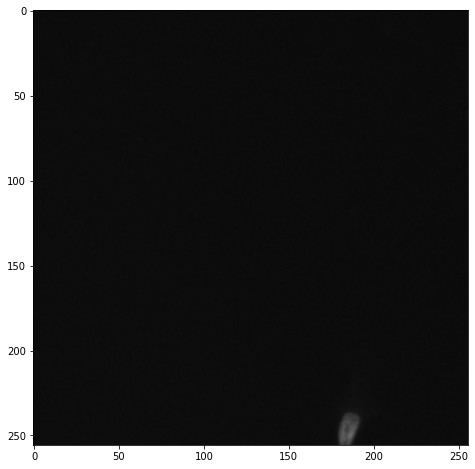

In [11]:
plt.imshow(read_image(train_df.iloc[train_df['num_masks'].argmin()]["image_path"]))

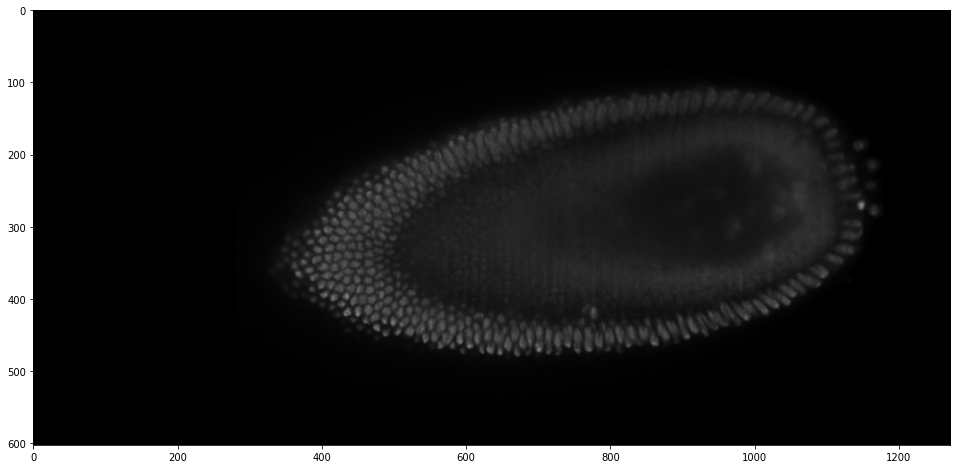

In [12]:
plt.imshow(read_image(train_df.iloc[train_df['num_masks'].argmax()]["image_path"]))

/home/raphael/Desktop/Quantor/kaggle_notebook/2018_Data_Science_Bowl/utils.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels(value_counts.index.values, rotation = 45)


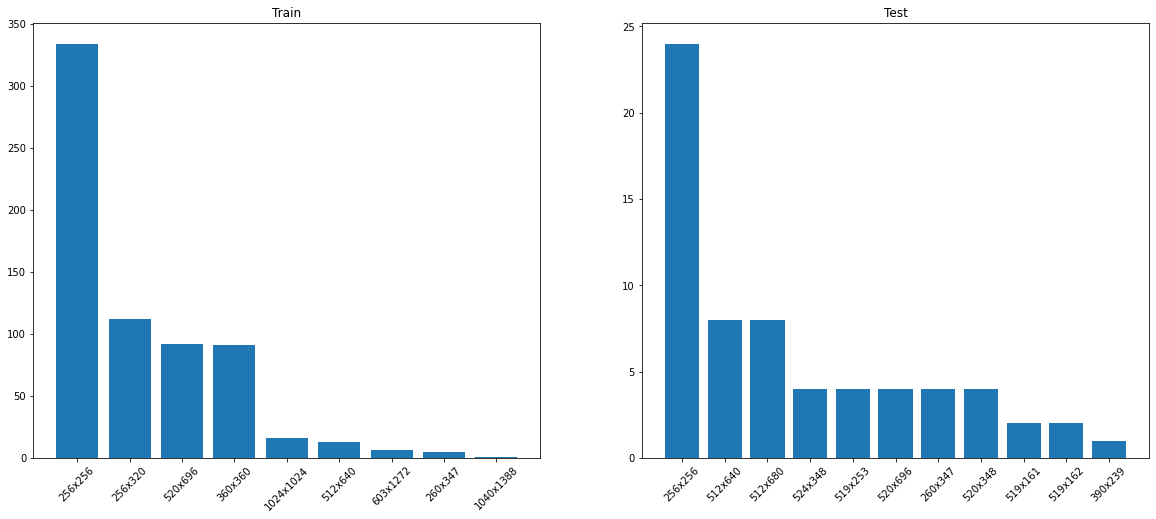

In [13]:
plot_data_shape_dist(train_df, test_df)

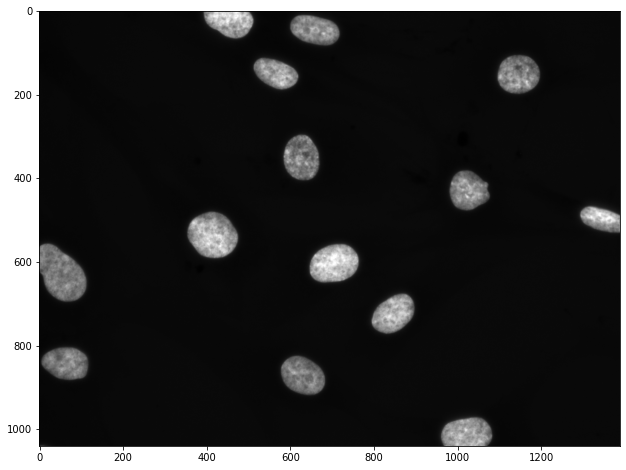

In [14]:
plt.imshow(read_image(train_df[train_df["shape"]=="1040x1388"]["image_path"].values[0]))

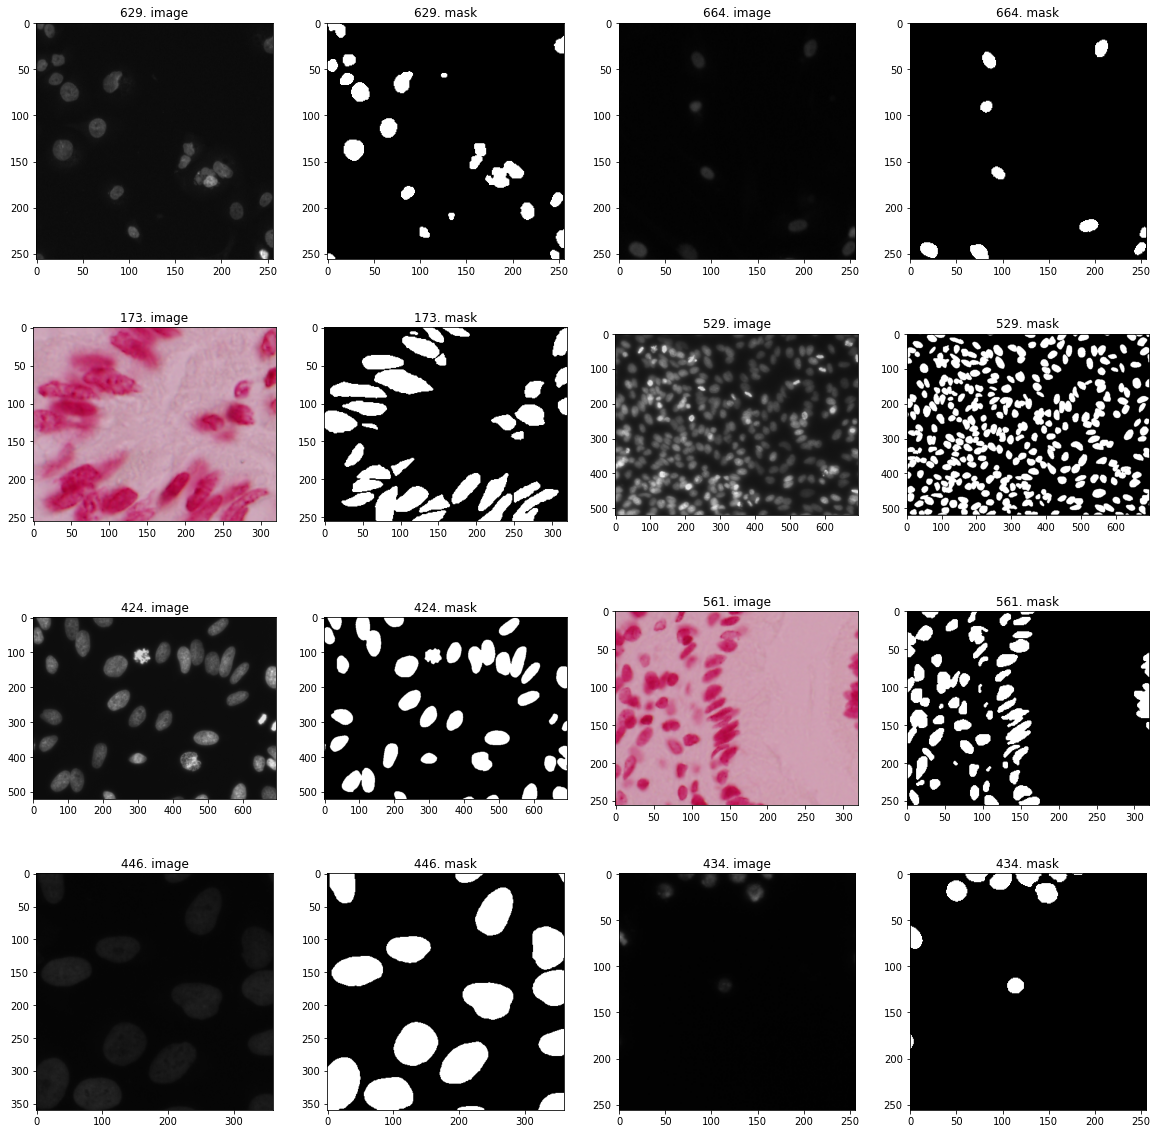

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))
for i in range(4):
    for j in range(2):
        n = np.random.randint(0, len(train_df))
        axs[i,j*2].imshow(read_image(train_df['image_path'].loc[n]))
        axs[i,j*2].set_title('{}. image'.format(n))
        axs[i,j*2+1].imshow(read_mask(train_df['mask_dir'].loc[n])[:,:,0], cmap='gray') 
        axs[i,j*2+1].set_title('{}. mask'.format(n))   

In [16]:
train_dataset = LoadDataSet(train_df, transform=get_train_transform())

image, mask = train_dataset.__getitem__(0)
print(f"image shape: {image.shape}")
print(f"mask shape:  {mask.shape}")

image shape: torch.Size([3, 256, 256])
mask shape:  torch.Size([1, 256, 256])


In [17]:
## Split train and validation set of split ratio 0.25.
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))

train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print(f"Train set size: {len(train_data)}")
print(f"Valid set size: {len(valid_data)}")

Train set size: 502
Valid set size: 168


In [18]:
model = UNet(3, 1)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

num_epochs = 10
criterion = DiceLoss()
accuracy_metric = IoULoss()
valid_loss_min = np.Inf

In [19]:
total_train_loss, total_train_score = [], []
total_valid_loss, total_valid_score = [], []

losses_value = 0
for epoch in range(num_epochs):
    train_loss, train_score = [], []
    valid_loss, valid_score = [], []
    
    # Train Loop
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
        x_train = torch.autograd.Variable(x_train)
        y_train = torch.autograd.Variable(y_train)
        optimizer.zero_grad()
        output = model(x_train)
        # Loss
        loss = criterion(output, y_train)
        losses_value = loss.item()
        # Score
        score = accuracy_metric(output, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())
        pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    # Validation Loop
    with torch.no_grad():
        for image, mask in val_loader:
            image = torch.autograd.Variable(image)
            mask = torch.autograd.Variable(mask)
            output = model(image)
            # Loss
            loss = criterion(output, mask)
            losses_value = loss.item()
            # Score
            score = accuracy_metric(output,mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"#################Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    # Save Checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    # save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

Epoch: 1, loss: 0.8841283321380615, IoU: 0.061508484184741974: 100%|█| 51/51 [04



###############Train Loss: 0.5651458081077126, Train IOU: 0.2843991864253493###############
#################Valid Loss: 0.4902678026872523, Valid IOU: 0.3465954521123101###############
Validation loss decreased (inf --> 0.490268).  Saving model ...


Epoch: 2, loss: 0.49627798795700073, IoU: 0.3366597294807434: 100%|█| 51/51 [04:



###############Train Loss: 0.4215072521976396, Train IOU: 0.41367918983394025###############
#################Valid Loss: 0.37388724088668823, Valid IOU: 0.46106332014588747###############
Validation loss decreased (0.490268 --> 0.373887).  Saving model ...


Epoch: 3, loss: 0.4780532121658325, IoU: 0.3531408905982971: 100%|█| 51/51 [03:5



###############Train Loss: 0.31975360360800054, Train IOU: 0.5231995915665346###############
#################Valid Loss: 0.3032997040187611, Valid IOU: 0.5376235912827885###############
Validation loss decreased (0.373887 --> 0.303300).  Saving model ...


Epoch: 4, loss: 0.21446245908737183, IoU: 0.6468269228935242: 100%|█| 51/51 [04:



###############Train Loss: 0.2539086528852874, Train IOU: 0.5995693323658962###############
#################Valid Loss: 0.22360626388998592, Valid IOU: 0.6369963603861192###############
Validation loss decreased (0.303300 --> 0.223606).  Saving model ...


Epoch: 5, loss: 0.2844168543815613, IoU: 0.5571368336677551: 100%|█| 51/51 [04:0



###############Train Loss: 0.18978802012462243, Train IOU: 0.683561335591709###############
#################Valid Loss: 0.17486688669990091, Valid IOU: 0.7045705774251152###############
Validation loss decreased (0.223606 --> 0.174867).  Saving model ...


Epoch: 6, loss: 0.5756332874298096, IoU: 0.2693448066711426: 100%|█| 51/51 [04:1



###############Train Loss: 0.19059876484029434, Train IOU: 0.6858191349927116###############
#################Valid Loss: 0.17316087203867295, Valid IOU: 0.7065242879530963###############
Validation loss decreased (0.174867 --> 0.173161).  Saving model ...


Epoch: 7, loss: 0.22994458675384521, IoU: 0.6260939836502075: 100%|█| 51/51 [04:



###############Train Loss: 0.16146327350653855, Train IOU: 0.7248673924044067###############
#################Valid Loss: 0.15292584896087646, Valid IOU: 0.7360525622087366###############
Validation loss decreased (0.173161 --> 0.152926).  Saving model ...


Epoch: 8, loss: 0.16453027725219727, IoU: 0.7174357175827026: 100%|█| 51/51 [03:



###############Train Loss: 0.15252765370350257, Train IOU: 0.7381360332171122###############
#################Valid Loss: 0.14379448399824254, Valid IOU: 0.7494780666687909###############
Validation loss decreased (0.152926 --> 0.143794).  Saving model ...


Epoch: 9, loss: 0.19323384761810303, IoU: 0.6761261820793152: 100%|█| 51/51 [03:



###############Train Loss: 0.13602314860213036, Train IOU: 0.7626330665513581###############
#################Valid Loss: 0.12958539584103754, Valid IOU: 0.7714366457041573###############
Validation loss decreased (0.143794 --> 0.129585).  Saving model ...


Epoch: 10, loss: 0.11189180612564087, IoU: 0.7987390756607056: 100%|█| 51/51 [04



###############Train Loss: 0.131630773637809, Train IOU: 0.7686025897661845###############
#################Valid Loss: 0.12929652368321137, Valid IOU: 0.771954101674697###############
Validation loss decreased (0.129585 --> 0.129297).  Saving model ...


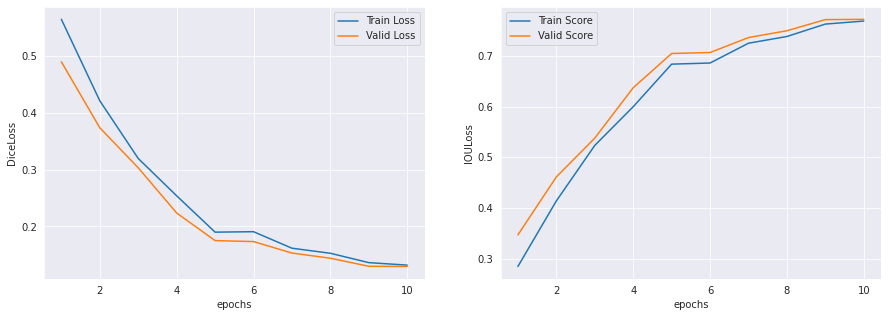

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(1, num_epochs+1), total_train_loss, label="Train Loss")
axs[0].plot(range(1, num_epochs+1), total_valid_loss, label="Valid Loss")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("DiceLoss")
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), total_train_score, label="Train Score")
axs[1].plot(range(1, num_epochs+1), total_valid_score, label="Valid Score")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("IOULoss")
axs[1].legend()

In [34]:
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

## Resources:
- https://github.com/milesial/Pytorch-UNet
- https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
- https://www.kaggle.com/arunmohan003/unet-starter-pytorch/output
- https://www.kaggle.com/godeep48/simple-unet-pytorch/execution